In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
images_folder = '../../images/' 
cmap = 'Set3'
colors = ['#8da0cb', '#e78ac3','#a6d854', '#ffd92f']
cmap_ = ListedColormap(colors)

In [3]:
users_and_metrics = pd.read_pickle('../data/users_and_metrics.pkl')
date_cols = ['min_date', 'max_date']
for key in users_and_metrics.keys():
    for col in date_cols:
        users_and_metrics[key][col] = pd.to_datetime(users_and_metrics[key][col])

In [4]:
users_calc = users_and_metrics['2019-2022']
metrics = users_calc.iloc[:, -5:]

# Descriptive statistics

In [5]:
describe = metrics.describe()
describe.loc['skew'] = metrics.skew()
describe.loc['kurt'] = metrics.kurtosis()
describe.T

,count,mean,std,min,25%,50%,75%,max,skew,kurt
productivity,45.0,0.526545,0.185774,0.115878,0.372335,0.548110,0.666406,0.945870,-0.072580,-0.374524
adaptability,45.0,0.494694,0.179488,0.082365,0.396942,0.510208,0.623386,0.795468,-0.570856,-0.123518
teamwork,45.0,0.498395,0.225198,0.000000,0.333333,0.511258,0.668932,0.860213,-0.306339,-0.542837
mentoring,45.0,0.430741,0.209256,0.191730,0.246130,0.345548,0.585215,0.909622,0.614791,-0.917847
performance,45.0,0.487594,0.086519,0.298415,0.437514,0.492169,0.560819,0.701076,-0.022140,-0.224881


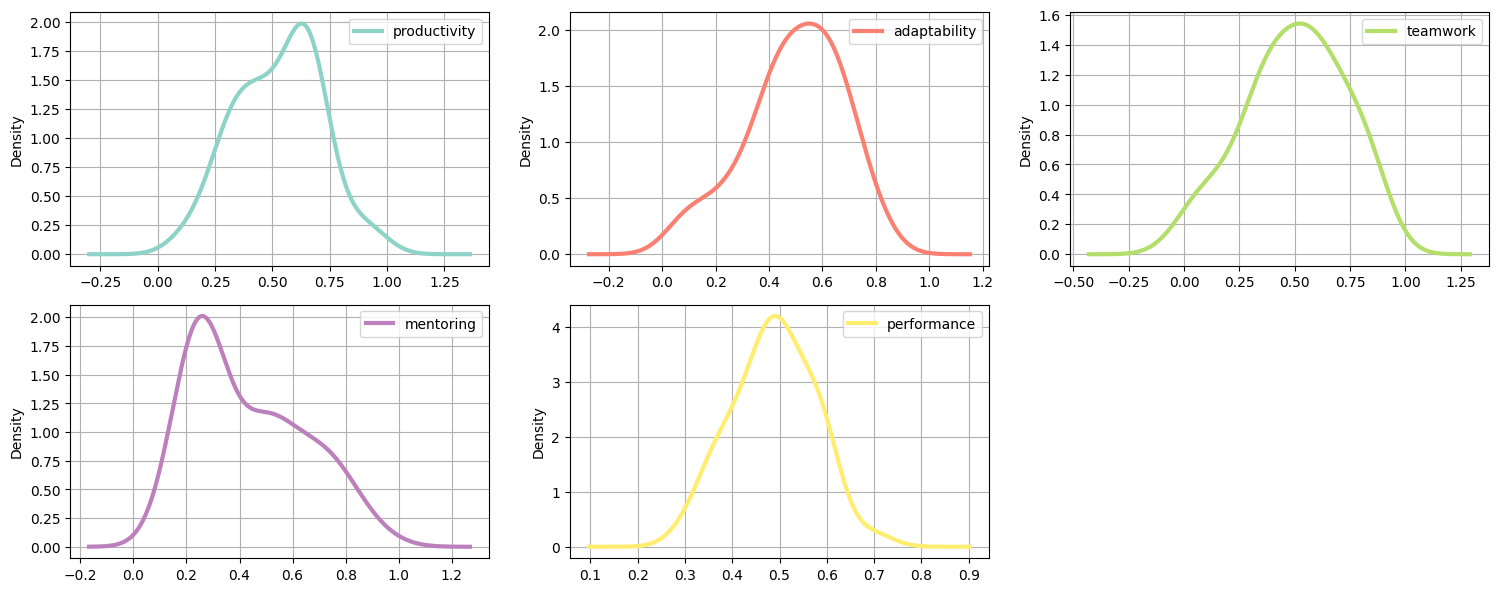

In [6]:
metrics.plot.kde(figsize = (15, 6), layout = (2, 3), subplots=True, cmap=cmap, sharey=False, sharex=False, grid=True, linewidth=3);
plt.tight_layout()
plt.savefig(images_folder + 'agg_distribution')

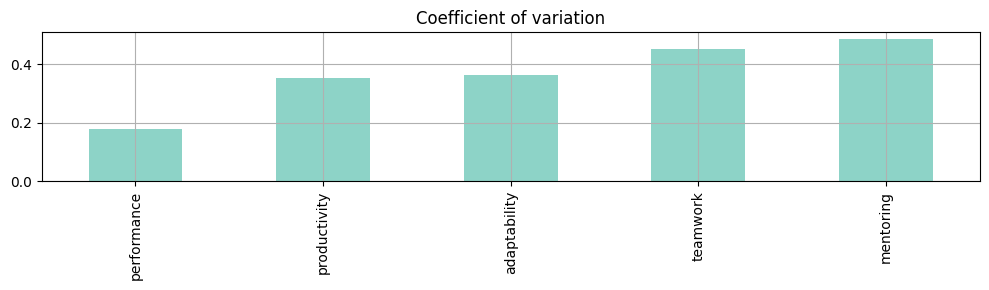

In [7]:
(describe.loc['std'] / describe.loc['mean']).sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Coefficient of variation', cmap=cmap);
plt.tight_layout()

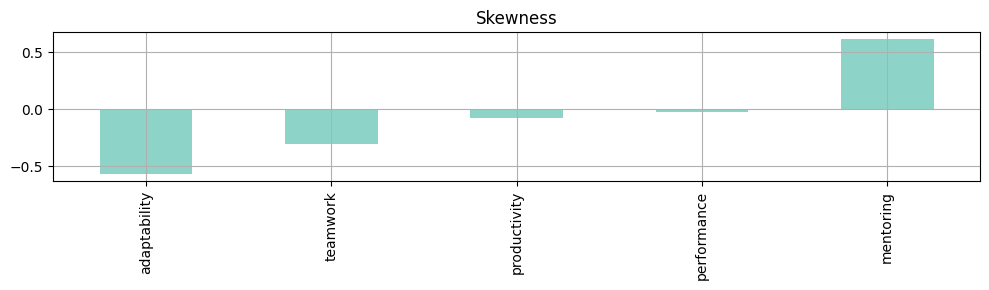

In [8]:
describe.loc['skew'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Skewness', cmap=cmap);
plt.tight_layout()

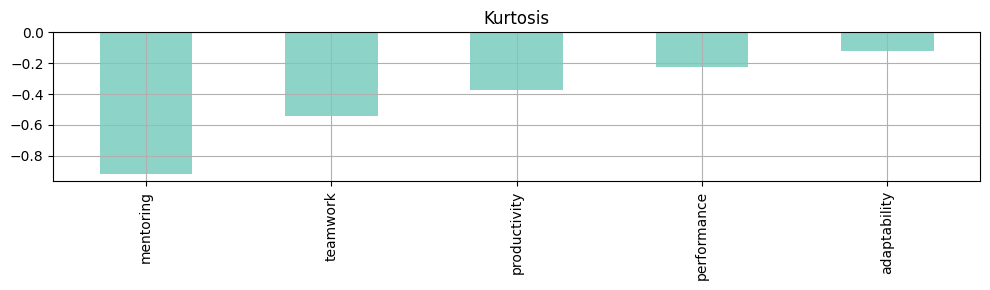

In [9]:
describe.loc['kurt'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Kurtosis', cmap=cmap);
plt.tight_layout()

# Redundancy

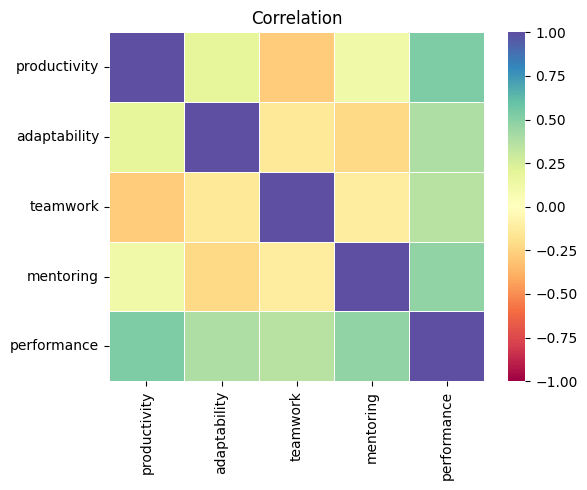

In [10]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
corr = metrics.corr()
sns.heatmap(corr, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax);
plt.title('Correlation');
plt.tight_layout()
plt.savefig(images_folder + 'agg_correlation')

# Stability

In [11]:
years = range(2019, 2023)
tags = list(users_and_metrics.keys())
yearly_metrics = {name: pd.concat([users_and_metrics[key][name] for key in tags], axis=1, keys=years) 
                  for name in metrics.columns}

In [12]:
n_iter = 100
yearly_random = {}
for i in range(n_iter):
    yearly_random[i] = {}
    for name in metrics.columns:
        yearly_random[i][name] = pd.DataFrame()
        for year in years:
            idx = yearly_metrics[name][year].dropna().index
            rnd = yearly_metrics[name][year].loc[idx].sample(frac=1, replace=False).reset_index(drop=True)
            yearly_random[i][name][year] = rnd

In [13]:
yearly_std = [yearly_metrics[name].std(axis=1).rename(name) for name in metrics.columns]
yearly_std = pd.concat(yearly_std, axis=1)

In [14]:
yearly_random_std = {}
for i in range(n_iter):
    yearly_random_std[i] = [yearly_random[i][name].std(axis=1).rename(name) for name in metrics.columns]
    yearly_random_std[i] = pd.concat(yearly_random_std[i], axis=1)

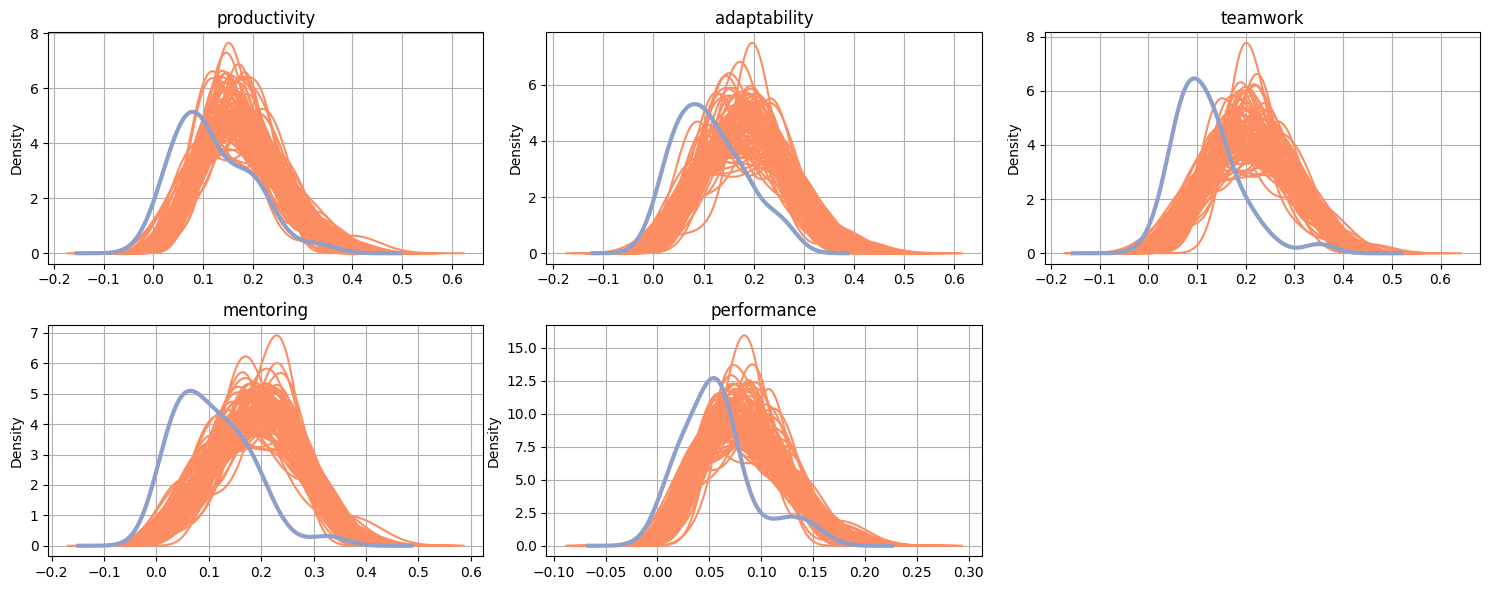

In [15]:
f = plt.figure(figsize=(15, 6))
for ii, name in enumerate(metrics.columns):
    ax = f.add_subplot(2, 3, ii + 1)
    for i in range(n_iter):
        yearly_random_std[i][name].plot.kde(color='#fc8d62')
    yearly_std[name].plot.kde(color='#8da0cb', linewidth=3, grid=True, title=name)
plt.tight_layout()
plt.savefig(images_folder + 'agg_stability')

# Comparison

In [16]:
order = metrics.sort_values(by='performance').index
order = list(order)
split = [order[:11], order[11:-11], order[-11:]]
[', '.join(x) for x in split]

['alba, leticia, raquel, elena, judith, olga, alicia, charo, julia, rocio, paz',
 'ana, celia, veronica, adela, maira, patricia, alejandra, tania, teresa, carlota, sara, carolina, pilar, gema, fatima, beatriz, isabel, mar, irene, luisa, lucia, victoria, marta',
 'carmen, eva, nuria, marina, encarna, amaya, lidia, angela, francisca, stella, pura']

In [17]:
keys=['top_user', 'top_value', 'bottom_user', 'bottom_value']
top_bottom = [metrics.idxmax(), metrics.max(), metrics.idxmin(), metrics.min()]
top_bottom = pd.concat(top_bottom, axis=1, keys=keys)
top_bottom

,top_user,top_value,bottom_user,bottom_value
productivity,stella,0.945870,alba,0.115878
adaptability,irene,0.795468,judith,0.082365
teamwork,victoria,0.860213,paz,0.000000
mentoring,marina,0.909622,alba,0.191730
performance,pura,0.701076,alba,0.298415


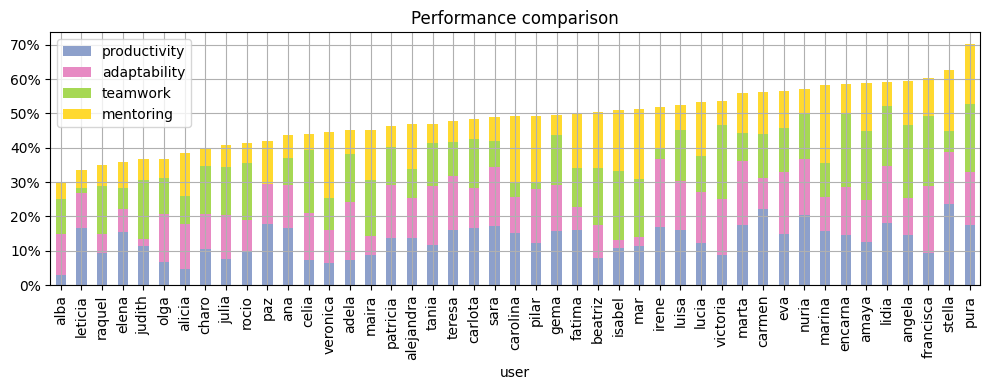

In [18]:
to_plot = (metrics.iloc[:, :4] * 0.25).loc[order]
ax = to_plot.plot.bar(stacked=True, figsize=(10, 4), grid=True, cmap=cmap_, title='Performance comparison');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison')

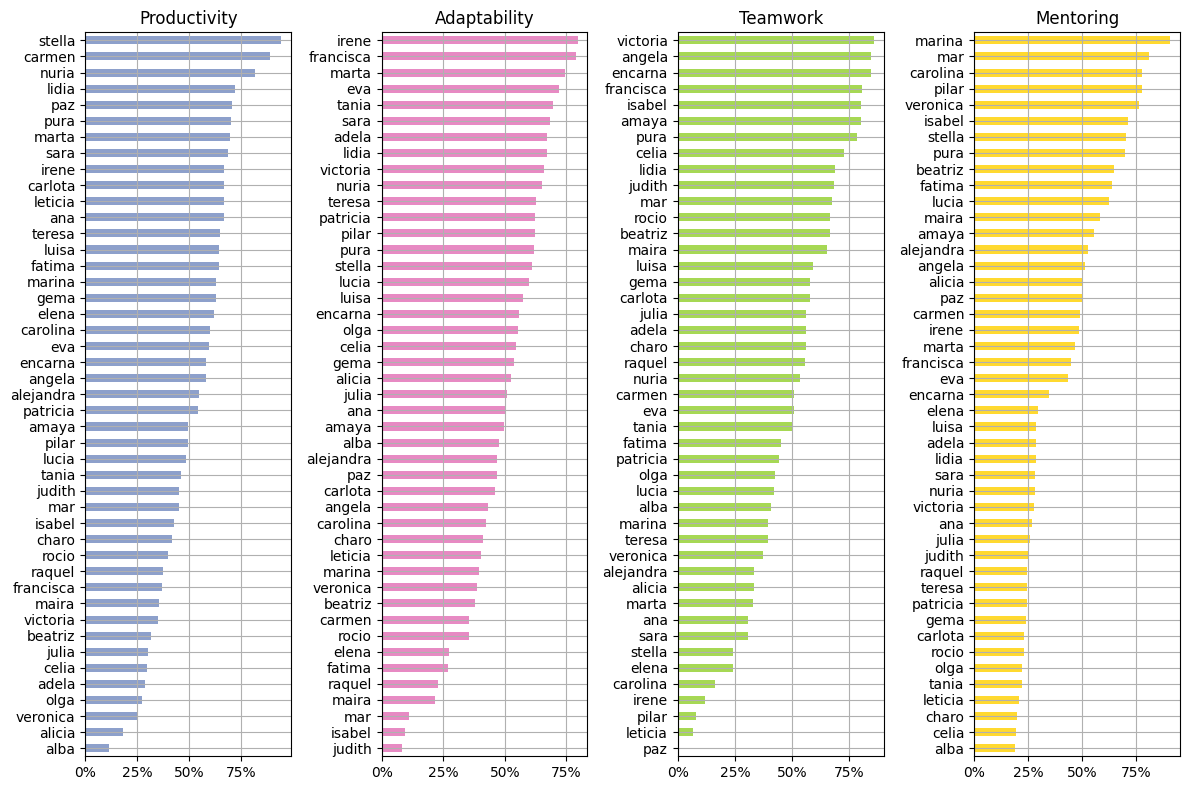

In [19]:
to_plot = metrics.iloc[:, :4].loc[order]
to_plot.index.name = ''

f = plt.figure(figsize=(12, 8))
for i, col in enumerate(to_plot.columns):
    ax = f.add_subplot(1, 4, i + 1)
    to_plot[col].sort_values().plot.barh(grid=True, legend=False, color=cmap_.colors[i], ax=ax, title=col.capitalize());
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison_by_dimension')

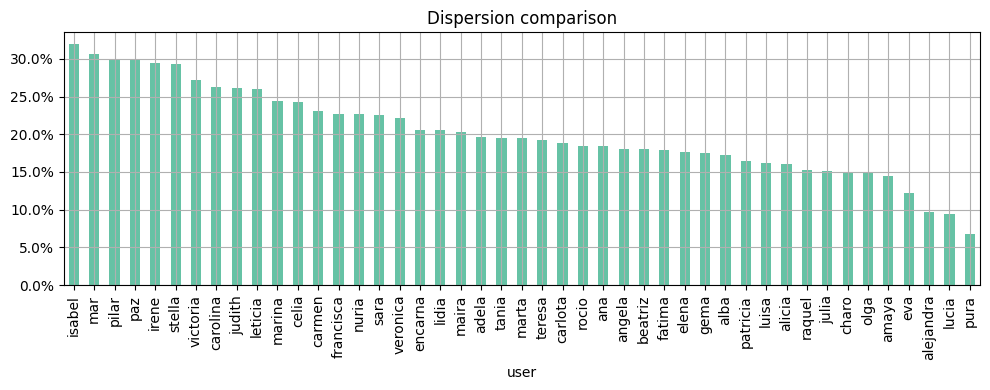

In [20]:
to_plot = metrics.iloc[:, :4].std(axis=1).sort_values(ascending=False)
ax = to_plot.plot.bar(figsize=(10, 4), grid=True, cmap=cmap_, title='Dispersion comparison', color='#66c2a5');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison_std')

# Clustering

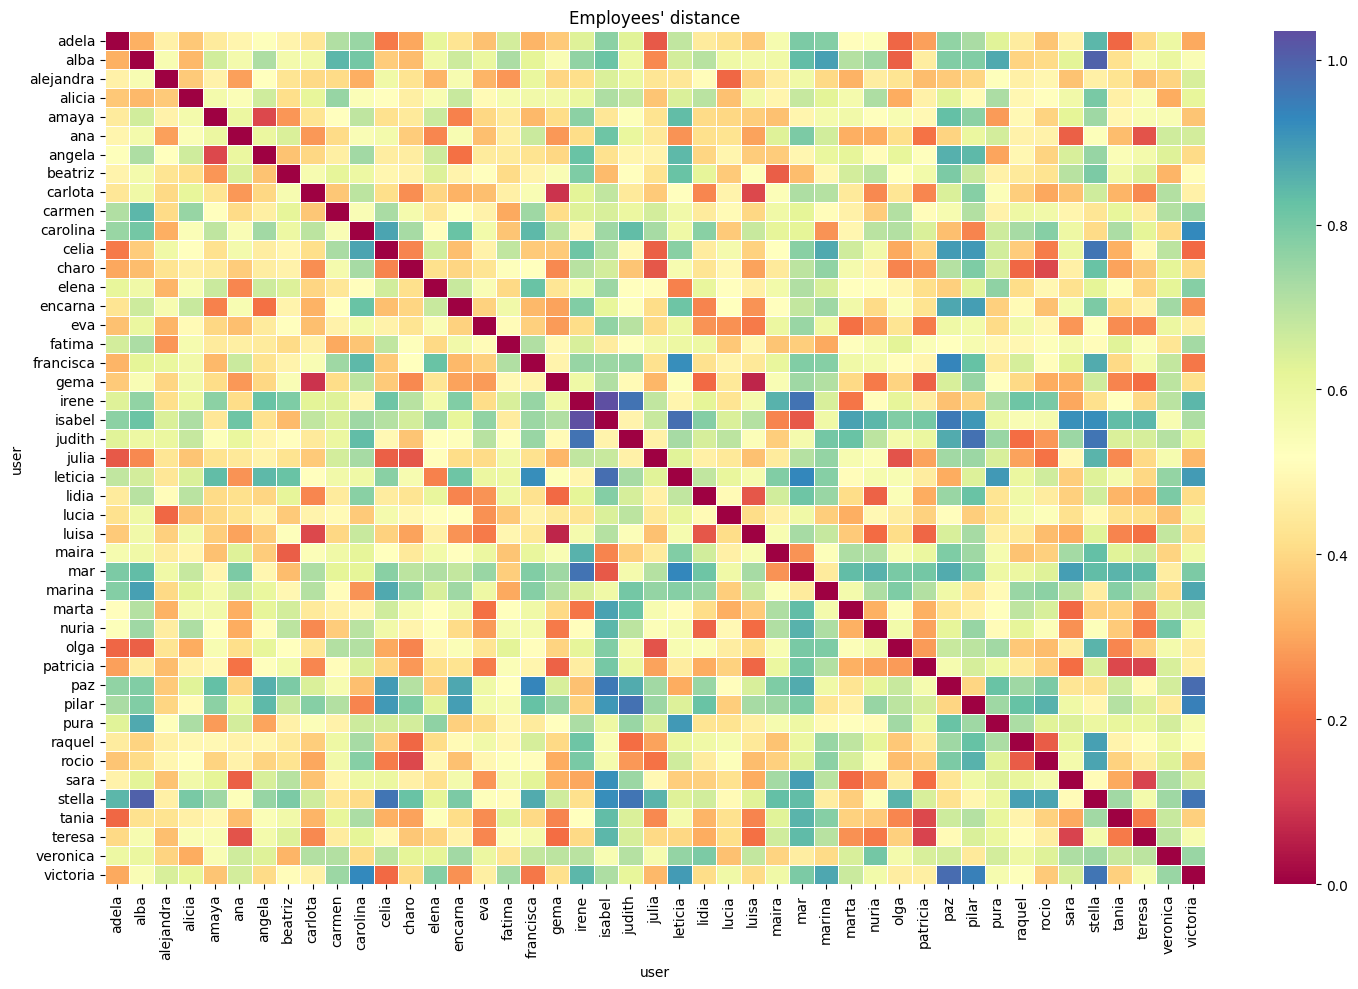

In [21]:
features = metrics.drop('performance', axis=1)
dist = DistanceMetric.get_metric('euclidean').pairwise(features)
dist = pd.DataFrame(dist, index=features.index, columns=features.index) 

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(dist, cmap="Spectral", annot=False, linewidths=.5, ax=ax); 
plt.title("Employees' distance");
plt.tight_layout()
plt.savefig(images_folder + 'clustering_distance')

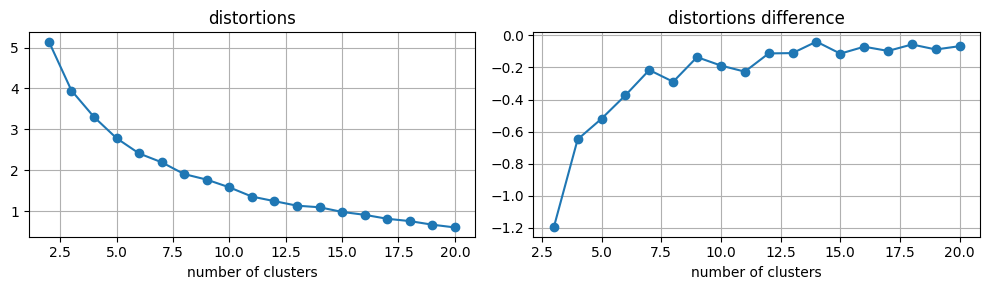

In [22]:
random_state = 17
n_clusters_range = range(2, 21)
distortions = {}
for n_clusters in n_clusters_range:
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = km.fit_predict(features)
    distortions[n_clusters] = km.inertia_
    
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(1, 2, 1)
pd.Series(distortions).plot(title='distortions', marker='o', ax=ax, grid=True);
plt.xlabel('number of clusters')
ax = f.add_subplot(1, 2, 2)
pd.Series(distortions).diff().plot(title='distortions difference', marker='o', ax=ax, grid=True);
plt.xlabel('number of clusters')

plt.tight_layout()
plt.savefig(images_folder + 'clustering_n_clusters')

In [23]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_labels = km.fit_predict(features)
kmeans_labels = pd.Series(kmeans_labels, index=features.index)

cluster  0 ( 14 ):  ['ana', 'carlota', 'carmen', 'elena', 'eva', 'gema', 'leticia', 'lidia', 'luisa', 'marta', 'nuria', 'patricia', 'sara', 'teresa']
cluster  1 ( 10 ):  ['alejandra', 'carolina', 'fatima', 'irene', 'lucia', 'marina', 'paz', 'pilar', 'stella', 'veronica']
cluster  2 ( 12 ):  ['adela', 'alba', 'alicia', 'celia', 'charo', 'francisca', 'julia', 'olga', 'raquel', 'rocio', 'tania', 'victoria']
cluster  3 ( 9 ):  ['amaya', 'angela', 'beatriz', 'encarna', 'isabel', 'judith', 'maira', 'mar', 'pura']


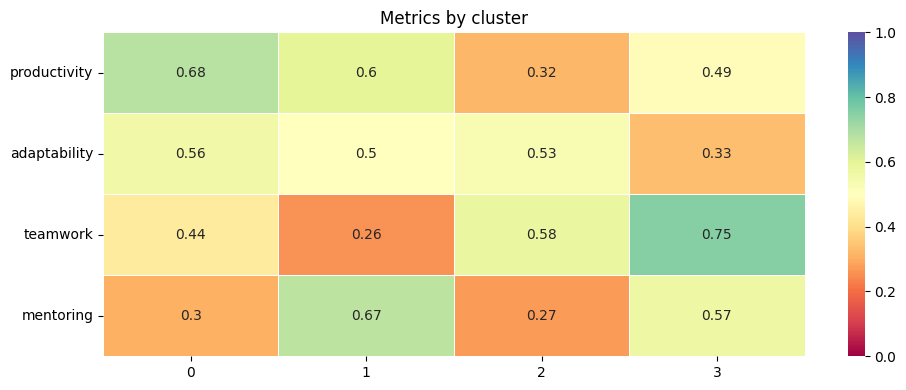

In [24]:
clusters_mean = []
for cluster in range(n_clusters):
    elements = kmeans_labels[kmeans_labels == cluster].index
    print('cluster ', cluster, '(', len(elements), '): ', list(elements))
    mean = features.loc[elements].mean().rename(cluster)
    clusters_mean.append(mean)
clusters_mean = pd.concat(clusters_mean, axis=1)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
sns.heatmap(clusters_mean, cmap="Spectral", annot=True, linewidths=.5, vmin=0, vmax=1, ax=ax); 
plt.title('Metrics by cluster');
plt.tight_layout()
plt.savefig(images_folder + 'clustering_heatmap')

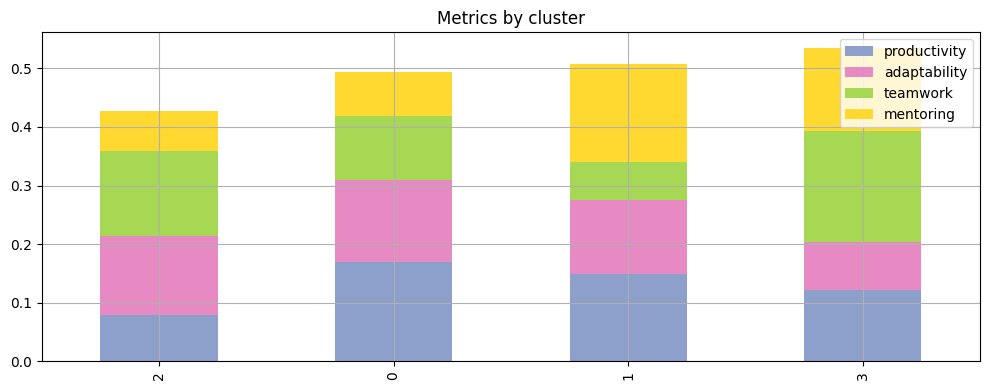

In [25]:
idx = clusters_mean.mean().sort_values().index
(clusters_mean[idx].T / features.shape[1]).plot.bar(stacked=True, cmap=cmap_, figsize=(10, 4), grid=True);
plt.title('Metrics by cluster');
plt.tight_layout()
plt.savefig(images_folder + 'clustering_comparison')

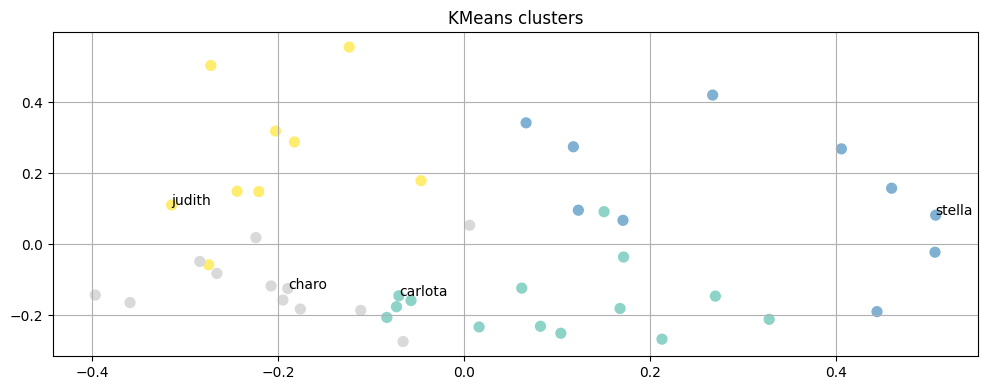

In [26]:
n_components = 2
estimator = PCA(n_components)
X_pca = estimator.fit_transform(features)
components_names = ['component_' + str(x) for x in range(n_components)]
pca_2d = pd.DataFrame(X_pca, columns=components_names, index=features.index)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)

plt.scatter(pca_2d['component_0'], pca_2d['component_1'], c=kmeans_labels, s=50, cmap=cmap)
plt.title('KMeans clusters') 
plt.grid()

samples = [kmeans_labels[kmeans_labels == n].sample(1).index[0] for n in range(n_clusters)]
for user in samples:
    ax.text(pca_2d.loc[user].iloc[0], pca_2d.loc[user].iloc[1], user)
plt.tight_layout()
plt.savefig(images_folder + 'clustering_pca')

In [27]:
c2 = pd.DataFrame(estimator.components_, columns=features.columns)
c2

,productivity,adaptability,teamwork,mentoring
0,0.454996,0.170554,-0.813971,0.318342
1,-0.101089,-0.542848,0.150462,0.820036


# Progress

In [28]:
years = range(2019, 2023)
tags = list(users_and_metrics.keys())
yearly_metrics = {name: pd.concat([users_and_metrics[key][name] for key in tags], axis=1, keys=years) 
                  for name in metrics.columns}

In [29]:
yearly = pd.DataFrame(yearly_metrics['performance'])

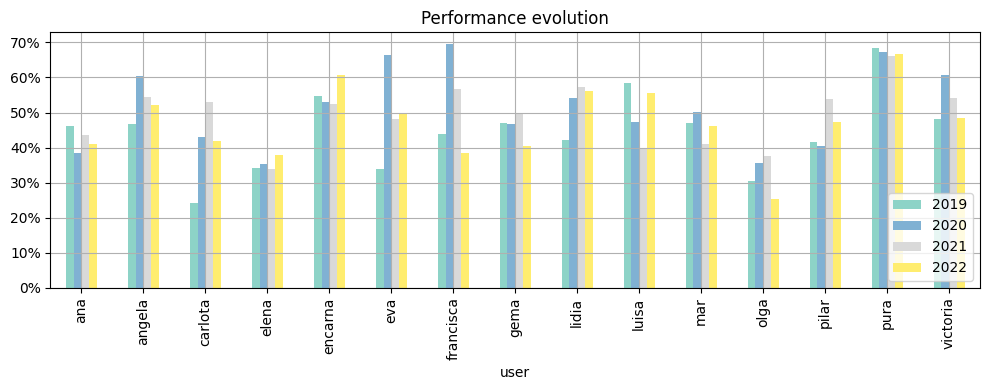

In [30]:
full = yearly[yearly.isna().sum(axis=1) == 0].index
ax = yearly.loc[full].plot.bar(figsize=(10, 4), grid=True, cmap=cmap, title='Performance evolution')
ax.legend(loc='lower right');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'progress_yearly')

In [31]:
ret = yearly.diff(axis=1)

In [32]:
ret_melt = ret.melt(var_name='year', value_name='performance_diff', ignore_index=False).dropna()

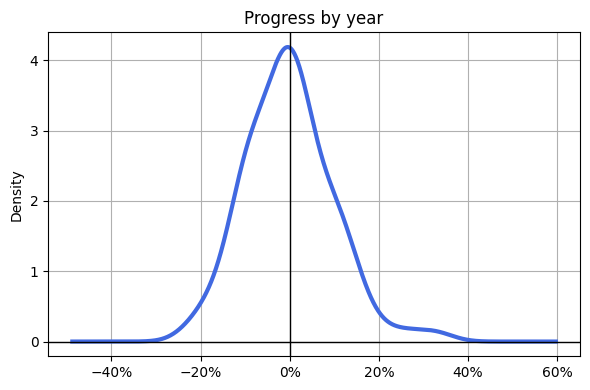

In [33]:
ax = ret_melt['performance_diff'].plot.kde(figsize=(6, 4), color='royalblue', grid=True, linewidth=3)
plt.title('Progress by year');
ax.axhline(0, color='k', linewidth=1);
ax.axvline(0, color='k', linewidth=1);
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'progress_distribution')

In [34]:
out_ = users_calc[users_calc['max_date'] < '20221201'].index
in_ = users_calc[users_calc['min_date'] > '20190131'].index

In [35]:
out_ = [x for x in out_ if x in ret.index and ret.loc[x].isna().sum() < 4]
in_ = [x for x in in_ if x in ret.index and ret.loc[x].isna().sum() < 4]

In [36]:
[len(out_), len(in_)]

[14, 18]

In [37]:
ini = ret_melt.reset_index().groupby(['user']).first().loc[in_]
fin = ret_melt.reset_index().groupby(['user']).last().loc[out_]

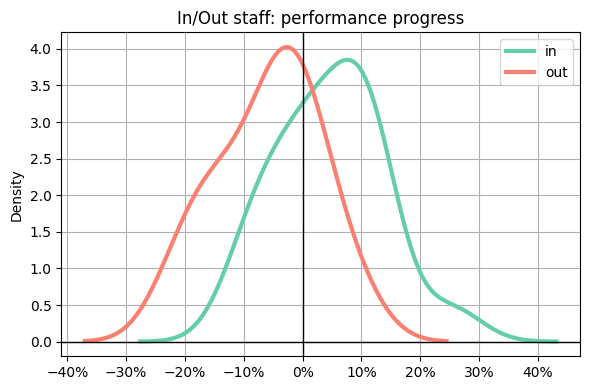

In [38]:
ini_ = ini['performance_diff'].sort_values().rename('in')
fin_ = fin['performance_diff'].sort_values().rename('out') 
ax = ini_.plot.kde(color='mediumaquamarine', figsize=(6, 4), legend=True, linewidth=3)
fin_.plot.kde(color='salmon', grid=True, ax=ax, legend=True, linewidth=3)
plt.title('In/Out staff: performance progress');
ax.axhline(0, color='k', linewidth=1);
ax.axvline(0, color='k', linewidth=1);
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()

plt.savefig(images_folder + 'progress_distribution_in_out')

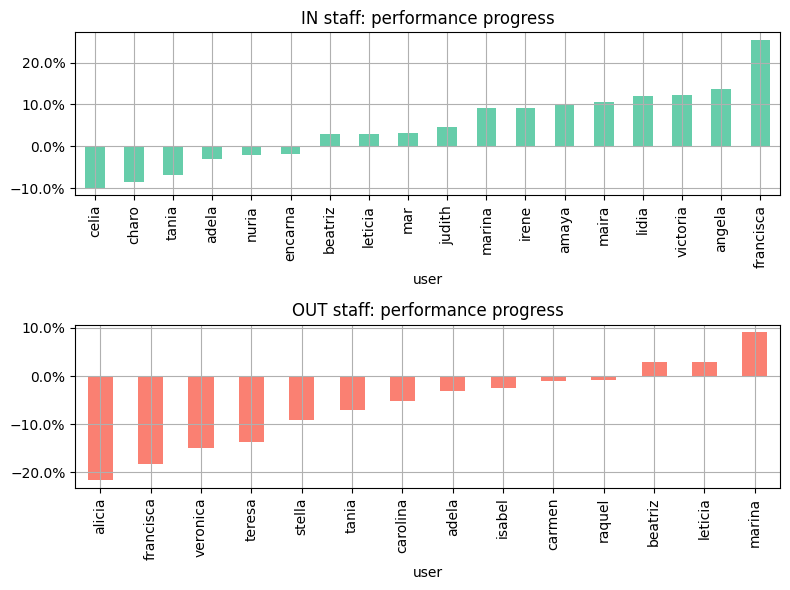

In [39]:
fig, ax = plt.subplots(2, 1, sharey=False, figsize=(8, 6))
ax = ax.ravel()

ini['performance_diff'].sort_values().plot.bar(ax=ax[0],
    grid=True, title='IN staff: performance progress', color='mediumaquamarine'); 
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))

fin['performance_diff'].sort_values().plot.bar(ax=ax[1],
    grid=True, title='OUT staff: performance progress', color='salmon'); 
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.tight_layout()
plt.savefig(images_folder + 'progress_in_out')

In [40]:
from calculate import get_metrics_dict, calculate_performance
metrics = get_metrics_dict()
metrics_abs = sum(list(metrics.values()), [])

In [41]:
years = range(2019, 2023)
absolute_metrics = []
for year in years:
    data = users_and_metrics[str(year)][metrics_abs]
    data['year'] = year
    absolute_metrics.append(data)
    
absolute_metrics = pd.concat(absolute_metrics)    

In [42]:
std_metrics = calculate_performance(absolute_metrics)
std_metrics['year'] = absolute_metrics['year']

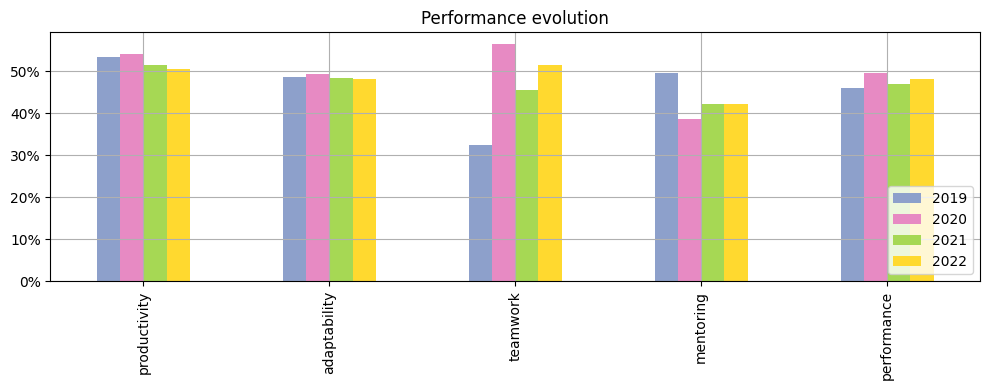

In [43]:
to_plot = std_metrics.groupby('year').mean()[list(metrics.keys()) + ['performance']].T
ax = to_plot.plot.bar(figsize=(10, 4), grid=True, cmap=cmap_, title='Performance evolution');
ax.legend(loc='lower right');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'performance_evolution')

In [44]:
to_plot

year,2019,2020,2021,2022
productivity,0.534640,0.539993,0.514891,0.506275
adaptability,0.487489,0.493061,0.483940,0.481632
teamwork,0.324021,0.564535,0.454637,0.515561
mentoring,0.495695,0.386508,0.422418,0.422127
performance,0.460461,0.496024,0.468972,0.481399
